In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models, datasets
from torchvision.models import  VGG19_Weights
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
## Step 1: Load and Preprocess Data
# Define transformations for images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for pre-trained model input
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard normalization for pre-trained models
])

In [ ]:
!unzip -qq ./chip_data.zip -d data

In [ ]:
# Load dataset from a folder (structured as: dataset/class_name/images)
dataset_path = "./data/dataset/"
train_dataset = datasets.ImageFolder(root=f"{dataset_path}/train", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{dataset_path}/test", transform=transform)

In [ ]:
# Display some input images
def show_sample_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(5, 5))
    for i in range(num_images):
        image, label = dataset[i]
        image = image.permute(1,
                              2, 0)  # Convert tensor format (C, H, W) to (H, W, C)
        axes[i].imshow(image)
        axes[i].set_title(dataset.classes[label])
        axes[i].axis("off")
    plt.show()

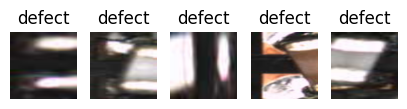

In [ ]:
# Show sample images from the training dataset
show_sample_images(train_dataset)

In [ ]:
# Get the total number of samples in the training dataset
print(f"Total number of training samples: {len(train_dataset)}")

# Get the shape of the first image in the dataset
first_image, label = train_dataset[0]
print(f"Shape of the first image: {first_image.shape}")

Total number of training samples: 172
Shape of the first image: torch.Size([3, 224, 224])


In [ ]:
# Get the total number of samples in the testing dataset
print(f"Total number of test samples: {len(test_dataset)}")

# Get the shape of the first image in the dataset
first_image1, label = test_dataset[0]
print(f"Shape of the first image: {first_image1.shape}")



Total number of test samples: 121
Shape of the first image: torch.Size([3, 224, 224])


In [ ]:
# Create DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
## Step 2: Load Pretrained Model and Modify for Transfer Learning
# Load a pre-trained VGG19 model
# write your code here
model=models.vgg19(weights=VGG19_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 80.2MB/s]


In [ ]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
from torchsummary import summary
# Print model summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
# Modify the final fully connected layer to match the dataset classes
# Write your code here
model.classifier[-1]=nn.Linear(model.classifier[-1].in_features,1)

In [ ]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
# Freeze all layers except the final layer
for param in model.features.parameters():
    param.requires_grad = False  # Freeze feature extractor layers

In [ ]:
# Include the Loss function and optimizer
criterion =nn.BCEWithLogitsLoss()
optimizer =optim.Adam(model.parameters(), lr=0.001)

In [ ]:
## Step 3: Train the Model
def train_model(model, train_loader,test_loader,num_epochs=100):
    train_losses = []
    val_losses = []
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # Compute validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels.unsqueeze(1).float())
                val_loss += loss.item()

        val_losses.append(val_loss / len(test_loader))
        model.train()

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')

    # Plot training and validation loss
    print("Name: ")
    print("Register Number: ")
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


In [ ]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Epoch [1/100], Train Loss: 0.7965, Validation Loss: 0.4082
Epoch [2/100], Train Loss: 0.2100, Validation Loss: 0.1750
Epoch [3/100], Train Loss: 0.0203, Validation Loss: 0.2497
Epoch [4/100], Train Loss: 0.0056, Validation Loss: 0.1599
Epoch [5/100], Train Loss: 0.0232, Validation Loss: 1.2238
Epoch [6/100], Train Loss: 0.0203, Validation Loss: 0.1360
Epoch [7/100], Train Loss: 0.0056, Validation Loss: 0.5425
Epoch [8/100], Train Loss: 0.0874, Validation Loss: 0.2339
Epoch [9/100], Train Loss: 0.0384, Validation Loss: 2.1924
Epoch [10/100], Train Loss: 0.0557, Validation Loss: 0.2899
Epoch [11/100], Train Loss: 0.0363, Validation Loss: 0.3011
Epoch [12/100], Train Loss: 0.0000, Validation Loss: 2.1840
Epoch [13/100], Train Loss: 0.0729, Validation Loss: 0.2241
Epoch [14/100], Train Loss: 0.0538, Validation Loss: 0.8166
Epoch [15/100], Train Loss: 0.2527, Validation Loss: 0.6694
Epoch [16/100], Train Loss: 0.1049, Validation Loss: 0.4285
Epoch [17/100], Train Loss: 0.2547, Validation Lo

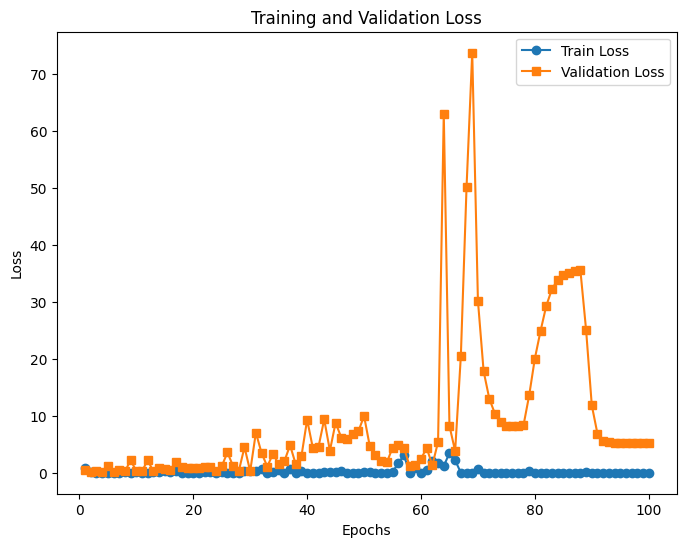

In [ ]:
# Train the model
train_model(model, train_loader,test_loader)


In [ ]:

## Step 4: Test the Model and Compute Confusion Matrix & Classification Report
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)  # Ensure shape [batch_size, 1]

            outputs = model(images)
            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).int()

            total += labels.size(0)
            correct += (predicted == labels.int()).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy().astype(int))

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

    # Compute confusion matrix
    class_names = ['Negative', 'Positive']  # You can rename as needed
    cm = confusion_matrix(all_labels, all_preds)
    print("Name:        ")
    print("Register Number:        ")
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Print classification report
    print("Name:        ")
    print("Register Number:        ")
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))


Test Accuracy: 0.9752
Name:        
Register Number:        


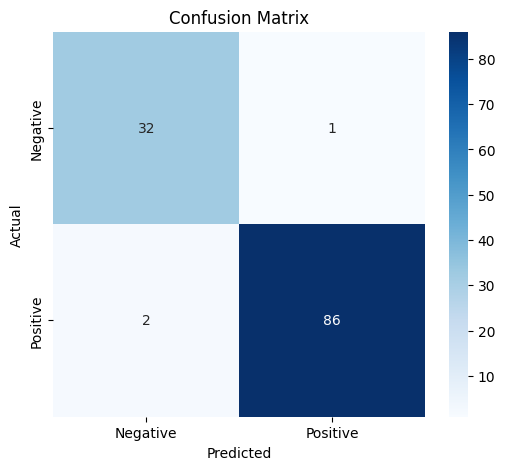

Name:        
Register Number:        
Classification Report:
              precision    recall  f1-score   support

    Negative       0.94      0.97      0.96        33
    Positive       0.99      0.98      0.98        88

    accuracy                           0.98       121
   macro avg       0.96      0.97      0.97       121
weighted avg       0.98      0.98      0.98       121



In [ ]:
# Evaluate the model
test_model(model, test_loader)



In [ ]:
## Step 5: Predict on a Single Image and Display It
def predict_image(model, image_index, dataset):
    model.eval()
    image, label = dataset[image_index]
    with torch.no_grad():
        # The image is already a tensor, just add batch dimension and send to device
        image_tensor = image.unsqueeze(0).to(device)
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
    class_names = dataset.classes  # Get class labels

    # Display the image
    # Need to convert the image back to PIL format for display
    image_to_display = transforms.ToPILImage()(image)
    print("Name:    ")
    print("Register Number: ")
    plt.figure(figsize=(4, 4))
    plt.imshow(image_to_display)
    plt.title(f'Actual: {class_names[label]}\nPredicted: {class_names[predicted.item()]}')
    plt.axis("off")
    plt.show()

Name:    
Register Number: 


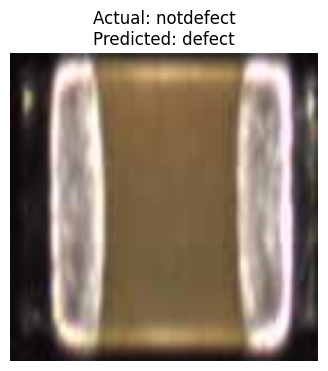

In [ ]:
# Example Prediction
predict_image(model, image_index=55, dataset=test_dataset)


Name:    
Register Number: 


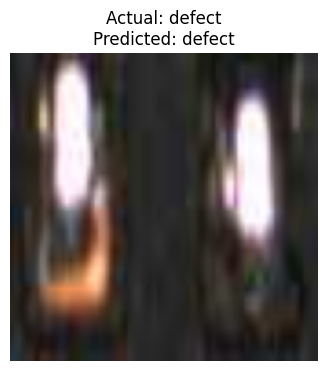

In [ ]:
#Example Prediction
predict_image(model, image_index=25, dataset=test_dataset)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models, datasets
from torchvision.models import  VGG19_Weights
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

## Step 1: Load and Preprocess Data
# Define transformations for images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for pre-trained model input
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard normalization for pre-trained models
])

!unzip -qq ./chip_data.zip -d data

# Load dataset from a folder (structured as: dataset/class_name/images)
dataset_path = "./data/dataset/"
train_dataset = datasets.ImageFolder(root=f"{dataset_path}/train", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{dataset_path}/test", transform=transform)

# Display some input images
def show_sample_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(5, 5))
    for i in range(num_images):
        image, label = dataset[i]
        image = image.permute(1,
                              2, 0)  # Convert tensor format (C, H, W) to (H, W, C)
        axes[i].imshow(image)
        axes[i].set_title(dataset.classes[label])
        axes[i].axis("off")
    plt.show()

# Show sample images from the training dataset
show_sample_images(train_dataset)

# Get the total number of samples in the training dataset
print(f"Total number of training samples: {len(train_dataset)}")

# Get the shape of the first image in the dataset
first_image, label = train_dataset[0]
print(f"Shape of the first image: {first_image.shape}")

# Get the total number of samples in the testing dataset
print(f"Total number of test samples: {len(test_dataset)}")

# Get the shape of the first image in the dataset
first_image1, label = test_dataset[0]
print(f"Shape of the first image: {first_image1.shape}")

# Create DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Step 2: Load Pretrained Model and Modify for Transfer Learning
# Load a pre-trained VGG19 model
# write your code here
model=models.vgg19(weights=VGG19_Weights.DEFAULT)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

from torchsummary import summary
# Print model summary
summary(model, input_size=(3, 224, 224))

# Modify the final fully connected layer to match the dataset classes
# Write your code here
model.classifier[-1]=nn.Linear(model.classifier[-1].in_features,1)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

summary(model, input_size=(3, 224, 224))

# Freeze all layers except the final layer
for param in model.features.parameters():
    param.requires_grad = False  # Freeze feature extractor layers


# Include the Loss function and optimizer
criterion =nn.BCEWithLogitsLoss()
optimizer =optim.Adam(model.parameters(), lr=0.001)

## Step 3: Train the Model
def train_model(model, train_loader,test_loader,num_epochs=100):
    train_losses = []
    val_losses = []
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # Compute validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels.unsqueeze(1).float())
                val_loss += loss.item()

        val_losses.append(val_loss / len(test_loader))
        model.train()

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')

    # Plot training and validation loss
    print("Name: ")
    print("Register Number: ")
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Train the model
train_model(model, train_loader,test_loader)


## Step 4: Test the Model and Compute Confusion Matrix & Classification Report
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)  # Ensure shape [batch_size, 1]

            outputs = model(images)
            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).int()

            total += labels.size(0)
            correct += (predicted == labels.int()).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy().astype(int))

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

    # Compute confusion matrix
    class_names = ['Negative', 'Positive']  # You can rename as needed
    cm = confusion_matrix(all_labels, all_preds)
    print("Name:        ")
    print("Register Number:        ")
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Print classification report
    print("Name:        ")
    print("Register Number:        ")
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

# Evaluate the model
test_model(model, test_loader)

## Step 5: Predict on a Single Image and Display It
def predict_image(model, image_index, dataset):
    model.eval()
    image, label = dataset[image_index]
    with torch.no_grad():
        # The image is already a tensor, just add batch dimension and send to device
        image_tensor = image.unsqueeze(0).to(device)
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
    class_names = dataset.classes  # Get class labels

    # Display the image
    # Need to convert the image back to PIL format for display
    image_to_display = transforms.ToPILImage()(image)
    print("Name:    ")
    print("Register Number: ")
    plt.figure(figsize=(4, 4))
    plt.imshow(image_to_display)
    plt.title(f'Actual: {class_names[label]}\nPredicted: {class_names[predicted.item()]}')
    plt.axis("off")
    plt.show()

# Example Prediction
predict_image(model, image_index=55, dataset=test_dataset)

#Example Prediction
predict_image(model, image_index=25, dataset=test_dataset)
